<a href="https://colab.research.google.com/github/KiarashVaziri/E4-Data-Analysis/blob/main/MultiModal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multi-Modal analysis of E4

# Packages

In [74]:
!pip install EMD-signal
from PyEMD import EMD
from PyEMD import EEMD

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [75]:
#%% PACKAGES
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import pandas as pd
from random import randint
import seaborn as sns
from scipy.signal import butter, filtfilt, lfilter, iirnotch, resample
from scipy.stats import pearsonr 
from scipy.fft import fft
from scipy import signal 
plt.rcParams['figure.figsize'] = [16, 8]
plt.rcParams.update({'font.size':18})

# Functions

In [ ]:
def mean(x):
  return np.mean(x, axis=-1)

def std(x):
  return np.std(x, axis=-1)

def var(x):
  return np.var(x, axis=-1)

def ptp(x):
  return np.ptp(x, axis=-1)

def rms(x):
  return np.sqrt(np.mean(x**2, axis=-1))

def skewness(x):
  return stats.skew(x, axis=-1)

def kurtosis(x):
  return stats.kurtosis(x, axis=-1)

def fft_(x, Fs=256):
  L = x.shape[0]
  Y = fft(x)
  P2 = np.abs(Y/L);
  P1 = P2[1:int(L/2)+1];
  P1[1:-1] = 2*P1[1:-1];
  f = Fs*np.arange(0, L/2)/L
  return f, P1

def maxfreq_single(x):
  f_, Y_ = fft_(x)
  fmax = f_[np.argmax(Y_)]
  return fmax

def maxfreq(X):
  tmp = np.array([])
  for x in X:
    fmax = maxfreq_single(x)
    tmp = np.hstack((tmp, fmax))
  return np.array(tmp)  

def meanfreq_single(x, fs=64):
  f, Pxx_den = signal.periodogram(x, fs)                              
  Pxx_den = np.reshape( Pxx_den, (1,-1) ) 
  width = np.tile(f[1]-f[0], (1, Pxx_den.shape[1]))
  f = np.reshape(f, (1, -1))
  P = Pxx_den * width
  pwr = np.sum(P)
  mnfreq = np.dot(P, f.T)/pwr
  return mnfreq.item()

def meanfreq(X, fs=64):
  tmp = np.array([])
  for x in X:
    fmax = meanfreq_single(x, fs)
    tmp = np.hstack((tmp, fmax))
  return np.array(tmp) 

def exfeatures(imfs, fs):
  mean_ = np.mean(imfs, axis=1)
  var_ = np.mean(imfs, axis=1)
  skewness_ = stats.skew(imfs, axis=1)
  kurtosis_ = stats.kurtosis(imfs, axis=1)
  meanfreq_ = meanfreq(imfs, fs=fs)
  maxfreq_ = maxfreq(imfs)

  epochfeatures = np.concatenate((mean_, var_, skewness_, kurtosis_, 
                                  meanfreq_, maxfreq_))
  return epochfeatures

# Load Data

In [ ]:
!pwd
%cd /content/drive/MyDrive/Colab\ Notebooks/PPRC/DATA
!pwd

/content
/content/drive/MyDrive/Colab Notebooks/PPRC/DATA
/content/drive/MyDrive/Colab Notebooks/PPRC/DATA


In [ ]:
# import OS module
import os

# Get the list of all files and directories
path = "."
dir_list = os.listdir(path)
dir_list.remove('Tables')
dir_list = np.sort(dir_list)
dir_list

array(['OH01_April 14 2022_e4 data', 'OH02_April 19 2022_e4 data',
       'OH03_April 20 2022_e4 data', 'OH04_April 22 2022_e4 data',
       'OH05_April 22 2022_e4 data', 'OH06_', 'OH07_May 3 2022_e4 data',
       'OH08_May 4 2022_e4 data', 'OH09_May 5 2022_e4 data',
       'OH10_May 10 2022_e4 data', 'OH11_May 16 2022_e4 data',
       'OH12_May 17 2022_e4 data', 'OH13_May 18 2022_e4 data',
       'OH14_May 19 2022_e4 data', 'OH15_May 25 2022_e4 data',
       'OH16_May 27 2022_e4 data', 'OH17_May 30 2022_e4 data',
       'OH18_June 1 2022_e4 data', 'OH19_June_8_2022_e4 data',
       'OH20_June_8_2022_e4 data', 'OH21_June_9_2022_e4 data',
       'OH22_June_10_2022_e4 data', 'OH23_June_13_2022_e4 data',
       'OH24_June_14_2022_e4 data', 'data.csv'], dtype='<U26')

In [76]:
#%% LOAD DATA
patient_no = 11
DIR = dir_list[patient_no-1]

In [77]:
#FIND TAGS
df = pd.read_csv(DIR+"/tags.csv", header=None)
tags = np.array(df)

sham_gvs = [11, 19, 20, 23]
gvs_sham = [9, 12, 13, 14, 16, 18, 21, 22, 24]
#dic_ = {2:{'sham':(0, 17), 'gvs':(18, -1)}}
dic_ = {}
for p in sham_gvs:
  dic_[p] = {'sham':(0, 20), 'gvs':(21, -1)}
for p in gvs_sham:
  dic_[p] = {'sham':(21, -1), 'gvs':(0, 20)}

In [78]:
modes = pd.DataFrame(index=['t','signal', 'fs', 'sham', 'sham_t', 'gvs', 'gvs_t',
                            'gvs_imfs', 'sham_imfs'], columns=['bvp', 'eda'])

### BVP ###
df_bvp = pd.read_csv(DIR+"/BVP.csv", header=None)
init_time = df_bvp[0][0]
fs_bvp = df_bvp[0][1].astype(int)
bvp = np.array(df_bvp[0][2:])
bvp_t = np.arange(0, bvp.shape[0]*1/fs_bvp, 1/fs_bvp)
modes['bvp']['fs'] = fs_bvp
modes['bvp']['signal'] = bvp
modes['bvp']['t'] = bvp_t


# ### EDA ###
df_eda = pd.read_csv(DIR+"/EDA.csv", header=None)
fs_eda = df_eda[0][1].astype(int)
eda = np.array(df_eda[0][2:])
eda_t = np.arange(0, eda.shape[0]*1/fs_eda, 1/fs_eda)
modes['eda']['fs'] = fs_eda
modes['eda']['signal'] = eda
modes['eda']['t'] = eda_t

# ### HR ###
# df_hr = pd.read_csv(DIR+"/HR.csv", header=None)
# fs_hr = df_hr[0][1].astype(int)
# hr = np.array(df_hr[0][2:])
# hr_t = np.arange(0, hr.shape[0]*1/fs_hr, 1/fs_hr)
# modes['hr']['fs'] = fs_hr
# modes['hr']['signal'] = hr
# modes['hr']['t'] = hr_t

# ### TEMP ###
# df_temp = pd.read_csv(DIR+"/TEMP.csv", header=None)
# fs_temp = df_temp[0][1].astype(int)
# temp = np.array(df_temp[0][2:])
# temp_t = np.arange(0, temp.shape[0]*1/fs_temp, 1/fs_temp)
# modes['temp']['fs'] = fs_temp
# modes['temp']['signal'] = temp
# modes['temp']['t'] = temp_t

In [79]:
# RAW INDICES
inds = []
for i in range(len(tags)):
    inds.append(tags[i] - init_time)

#inds = [int(i)+64*40 for i in inds]
inds = [int(i) for i in inds]

sham1, sham2 = inds[dic_[patient_no]['sham'][0]], inds[dic_[patient_no]['sham'][1]]
gvs1, gvs2 = inds[dic_[patient_no]['gvs'][0]], inds[dic_[patient_no]['gvs'][1]]

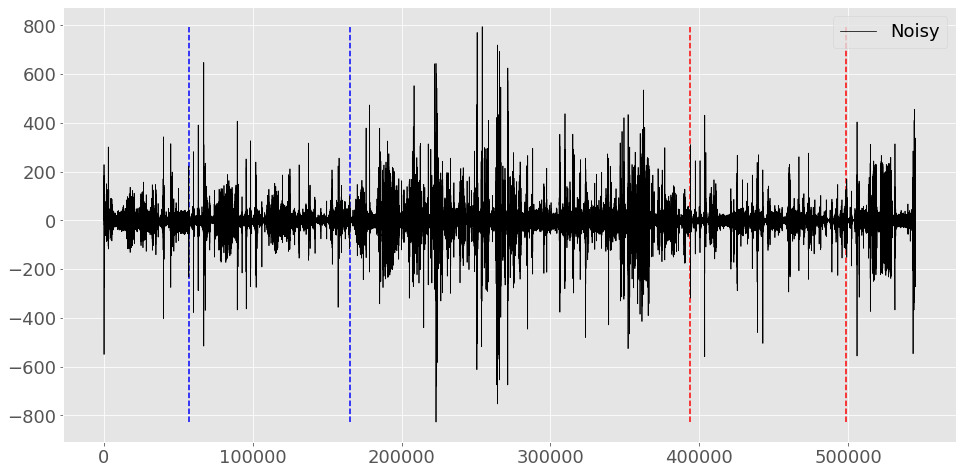

In [80]:
plt.figure()
sham1, sham2 = inds[dic_[patient_no]['sham'][0]], inds[dic_[patient_no]['sham'][1]]
gvs1, gvs2 = inds[dic_[patient_no]['gvs'][0]], inds[dic_[patient_no]['gvs'][1]]
plt.plot(bvp, color='black', linewidth=0.75, label='Noisy')
plt.vlines(x = [sham1*fs_bvp, sham2*fs_bvp], ymin=min(bvp), ymax=max(bvp), colors = 'blue', ls='--')
plt.vlines(x = [gvs1*fs_bvp, gvs2*fs_bvp], ymin=min(bvp), ymax=max(bvp), colors = 'red', ls='--')
plt.legend()

# EMD

In [81]:
for mode in modes:
  signal_ = modes[mode]['signal']
  t = modes[mode]['t']
  fs = modes[mode]['fs']
  modes[mode]['sham'] = signal_[sham1*fs:sham2*fs]
  modes[mode]['sham_t'] = t[sham1*fs:sham2*fs]
  modes[mode]['gvs'] = signal_[gvs1*fs:gvs2*fs]
  modes[mode]['gvs_t'] = t[gvs1*fs:gvs2*fs]

In [82]:
epoch_time = 15
N_epochsgvs = len(modes['bvp']['gvs']) // int(epoch_time * modes['bvp']['fs'])
N_epochssham = len(modes['bvp']['sham']) // int(epoch_time * modes['bvp']['fs'])
N_epochs = N_epochsgvs + N_epochssham
N_imfs = 5
for m in modes:
  ### GVS ###
  gvs = modes[m]['gvs']
  gvs_t = modes[m]['gvs_t']
  imfs = EEMD().emd(gvs, gvs_t, max_imf=N_imfs-1)
  modes[m]['gvs_imfs'] = imfs
  ### SHAM ###
  sham = modes[m]['sham']
  sham_t = modes[m]['sham_t']
  imfs = EEMD().emd(sham, sham_t, max_imf=N_imfs-1)
  modes[m]['sham_imfs'] = imfs

In [83]:
N_modes = len(modes.columns)
N_f = 6
N_features = N_modes * N_imfs * N_f
farray = [f'f{i}' for i in range(1, N_features+1)]
df_features = pd.DataFrame(columns=farray)
df_features['trial'] = 'gvs'
df_features['position'] = 'lying'
df_features.tail()

,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,...,f53,f54,f55,f56,f57,f58,f59,f60,trial,position


In [86]:
for k in range(N_epochs):
  trial = ''  # gvs/sham
  epochfeatures = np.array([])
  for m in modes:
    fs = modes[m]['fs']
    t = modes[m]['t']
    delta = int(epoch_time * fs)
    if k < N_epochsgvs:
      imfs = modes[m]['gvs_imfs']
      trial = 'gvs'
      features = exfeatures(imfs[:, k*delta:(k+1)*delta], fs=fs)
    else:
      imfs = modes[m]['sham_imfs']
      trial = 'sham'
      features = exfeatures(imfs[:, (k-N_epochsgvs)*delta:(k+1-N_epochsgvs)*delta], fs=fs)
    
    print(f'Epoch:{k}, trial:{trial}, Mode:{m}, IMFs:{imfs.shape}')
    ####################
    # EXTRACT FEATURES #
    # 1. mean
    # 2. std
    # 5. mean frequency
    # 6. max frequency
    # 7. time to rise
    # 8. time to fall
    # 9. entropy (2d)
    ####################
    epochfeatures = np.append(epochfeatures, features)
    print(f'Shape of extracted features: {epochfeatures.shape}')
  df_features.loc[k, farray] = epochfeatures
  df_features.loc[k, 'trial'] = trial

Epoch:0, trial:gvs, Mode:bvp, IMFs:(5, 105024)
Shape of extracted features: (30,)
Epoch:0, trial:gvs, Mode:eda, IMFs:(5, 6564)
Shape of extracted features: (60,)
Epoch:1, trial:gvs, Mode:bvp, IMFs:(5, 105024)
Shape of extracted features: (30,)
Epoch:1, trial:gvs, Mode:eda, IMFs:(5, 6564)
Shape of extracted features: (60,)
Epoch:2, trial:gvs, Mode:bvp, IMFs:(5, 105024)
Shape of extracted features: (30,)
Epoch:2, trial:gvs, Mode:eda, IMFs:(5, 6564)
Shape of extracted features: (60,)
Epoch:3, trial:gvs, Mode:bvp, IMFs:(5, 105024)
Shape of extracted features: (30,)
Epoch:3, trial:gvs, Mode:eda, IMFs:(5, 6564)
Shape of extracted features: (60,)
Epoch:4, trial:gvs, Mode:bvp, IMFs:(5, 105024)
Shape of extracted features: (30,)
Epoch:4, trial:gvs, Mode:eda, IMFs:(5, 6564)
Shape of extracted features: (60,)
Epoch:5, trial:gvs, Mode:bvp, IMFs:(5, 105024)
Shape of extracted features: (30,)
Epoch:5, trial:gvs, Mode:eda, IMFs:(5, 6564)
Shape of extracted features: (60,)
Epoch:6, trial:gvs, Mode:bvp

In [87]:
df_features

,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,...,f53,f54,f55,f56,f57,f58,f59,f60,trial,position
0,-0.002919,1.900608,-0.224166,0.574752,-1.959547,-0.002919,1.900608,-0.224166,0.574752,-1.959547,...,0.431843,0.259864,0.139381,89.6,29.866667,25.6,12.8,4.266667,gvs,NaN
1,-0.099683,1.748288,0.038376,-0.395614,-1.369128,-0.099683,1.748288,0.038376,-0.395614,-1.369128,...,0.441732,0.302428,0.128485,98.133333,42.666667,25.6,12.8,0.0,gvs,NaN
2,0.00442,0.198912,0.289828,-0.156344,-0.393713,0.00442,0.198912,0.289828,-0.156344,-0.393713,...,0.599619,0.325744,0.08128,110.933333,55.466667,38.4,17.066667,0.0,gvs,NaN
3,0.019489,-0.014481,-0.400136,0.279975,-0.043638,0.019489,-0.014481,-0.400136,0.279975,-0.043638,...,0.43005,0.208211,0.091507,98.133333,59.733333,17.066667,8.533333,0.0,gvs,NaN
4,-0.018843,-0.080557,1.861026,-0.091711,-1.370905,-0.018843,-0.080557,1.861026,-0.091711,-1.370905,...,0.431392,0.319595,0.191478,98.133333,51.2,21.333333,17.066667,4.266667,gvs,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
216,-0.145684,-0.118261,-0.50038,-0.108528,2.399894,-0.145684,-0.118261,-0.50038,-0.108528,2.399894,...,0.289486,0.205352,0.169292,8.533333,25.6,12.8,8.533333,4.266667,sham,NaN
217,-0.042976,0.018118,-0.054649,-0.122054,0.139811,-0.042976,0.018118,-0.054649,-0.122054,0.139811,...,0.319034,0.156711,0.245595,93.866667,59.733333,12.8,4.266667,12.8,sham,NaN
218,-0.02994,-0.012784,0.271741,0.154706,-0.088557,-0.02994,-0.012784,0.271741,0.154706,-0.088557,...,0.390106,0.251903,0.126073,42.666667,21.333333,21.333333,12.8,4.266667,sham,NaN
219,0.091868,0.000673,-0.096331,0.042353,-0.221085,0.091868,0.000673,-0.096331,0.042353,-0.221085,...,0.420437,0.364447,0.242782,68.266667,51.2,21.333333,17.066667,8.533333,sham,NaN


# Classification

In [88]:
# Importing LabelEncoder from Sklearn
# library from preprocessing Module.
from sklearn.preprocessing import LabelEncoder

# Creating a instance of label Encoder.
le = LabelEncoder()

# Using .fit_transform function to fit label
# encoder and return encoded label
label = le.fit_transform(df_features['trial'])

# printing label
label


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1])

In [89]:
# removing the column 'Purchased' from df
# as it is of no use now.
df_features.drop("trial", axis=1, inplace=True)

# Appending the array to our dataFrame
# with column name 'Purchased'
df_features["trial"] = label

df_features.drop('position', axis=1, inplace=True)
# printing Dataframe
df_features


,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,...,f52,f53,f54,f55,f56,f57,f58,f59,f60,trial
0,-0.002919,1.900608,-0.224166,0.574752,-1.959547,-0.002919,1.900608,-0.224166,0.574752,-1.959547,...,0.779131,0.431843,0.259864,0.139381,89.6,29.866667,25.6,12.8,4.266667,0
1,-0.099683,1.748288,0.038376,-0.395614,-1.369128,-0.099683,1.748288,0.038376,-0.395614,-1.369128,...,0.673237,0.441732,0.302428,0.128485,98.133333,42.666667,25.6,12.8,0.0,0
2,0.00442,0.198912,0.289828,-0.156344,-0.393713,0.00442,0.198912,0.289828,-0.156344,-0.393713,...,0.830857,0.599619,0.325744,0.08128,110.933333,55.466667,38.4,17.066667,0.0,0
3,0.019489,-0.014481,-0.400136,0.279975,-0.043638,0.019489,-0.014481,-0.400136,0.279975,-0.043638,...,0.902421,0.43005,0.208211,0.091507,98.133333,59.733333,17.066667,8.533333,0.0,0
4,-0.018843,-0.080557,1.861026,-0.091711,-1.370905,-0.018843,-0.080557,1.861026,-0.091711,-1.370905,...,0.881747,0.431392,0.319595,0.191478,98.133333,51.2,21.333333,17.066667,4.266667,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
216,-0.145684,-0.118261,-0.50038,-0.108528,2.399894,-0.145684,-0.118261,-0.50038,-0.108528,2.399894,...,0.481405,0.289486,0.205352,0.169292,8.533333,25.6,12.8,8.533333,4.266667,1
217,-0.042976,0.018118,-0.054649,-0.122054,0.139811,-0.042976,0.018118,-0.054649,-0.122054,0.139811,...,0.795752,0.319034,0.156711,0.245595,93.866667,59.733333,12.8,4.266667,12.8,1
218,-0.02994,-0.012784,0.271741,0.154706,-0.088557,-0.02994,-0.012784,0.271741,0.154706,-0.088557,...,0.508973,0.390106,0.251903,0.126073,42.666667,21.333333,21.333333,12.8,4.266667,1
219,0.091868,0.000673,-0.096331,0.042353,-0.221085,0.091868,0.000673,-0.096331,0.042353,-0.221085,...,0.820893,0.420437,0.364447,0.242782,68.266667,51.2,21.333333,17.066667,8.533333,1


In [90]:
y = df_features.pop('trial')

In [91]:
df_features,y

(           f1        f2        f3        f4        f5        f6        f7  \
 0   -0.002919  1.900608 -0.224166  0.574752 -1.959547 -0.002919  1.900608   
 1   -0.099683  1.748288  0.038376 -0.395614 -1.369128 -0.099683  1.748288   
 2     0.00442  0.198912  0.289828 -0.156344 -0.393713   0.00442  0.198912   
 3    0.019489 -0.014481 -0.400136  0.279975 -0.043638  0.019489 -0.014481   
 4   -0.018843 -0.080557  1.861026 -0.091711 -1.370905 -0.018843 -0.080557   
 ..        ...       ...       ...       ...       ...       ...       ...   
 216 -0.145684 -0.118261  -0.50038 -0.108528  2.399894 -0.145684 -0.118261   
 217 -0.042976  0.018118 -0.054649 -0.122054  0.139811 -0.042976  0.018118   
 218  -0.02994 -0.012784  0.271741  0.154706 -0.088557  -0.02994 -0.012784   
 219  0.091868  0.000673 -0.096331  0.042353 -0.221085  0.091868  0.000673   
 220   0.03094 -0.040959 -0.042461 -0.125742 -0.123445   0.03094 -0.040959   
 
            f8        f9       f10  ...       f51       f52   

In [92]:
# ONLY SVM
from sklearn.model_selection import train_test_split
from sklearn import svm
X = df_features.values
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state=42,
                                                    shuffle=True,
                                                    test_size = 0.25)

clf = svm.SVC(kernel='linear')
clf.fit(X_train, y_train)
clf.score(X_train, y_train), clf.score(X_test, y_test)

(0.9030303030303031, 0.7857142857142857)

In [93]:
# Different Classifier
def split(df,label):
    X_tr, X_te, Y_tr, Y_te = train_test_split(df, label, test_size=0.25, random_state=42)
    return X_tr, X_te, Y_tr, Y_te

from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold, cross_val_score

classifiers = ['LinearSVM', 'RadialSVM', 
               'Logistic',  'RandomForest', 
               'AdaBoost',  'DecisionTree', 
               'KNeighbors','GradientBoosting']

models = [svm.SVC(kernel='linear'),
          svm.SVC(kernel='rbf'),
          LogisticRegression(max_iter = 1000),
          RandomForestClassifier(n_estimators=200, random_state=0),
          AdaBoostClassifier(random_state = 0),
          DecisionTreeClassifier(random_state=0),
          KNeighborsClassifier(),
          GradientBoostingClassifier(random_state=0)]

In [94]:
def acc_score(df,label):
    Score = pd.DataFrame({"Classifier":classifiers})
    j = 0
    acc = []
    X_train,X_test,Y_train,Y_test = split(df,label)
    for i in models:
        model = i
        model.fit(X_train,Y_train)
        predictions = model.predict(X_test)
        acc.append(accuracy_score(Y_test,predictions))
        j = j+1     
    Score["Accuracy"] = acc
    Score.sort_values(by="Accuracy", ascending=False,inplace = True)
    Score.reset_index(drop=True, inplace=True)
    return Score

def plot(score,x,y,c = "b"):
    gen = [1,2,3,4,5]
    plt.figure(figsize=(6,4))
    ax = sns.pointplot(x=gen, y=score,color = c )
    ax.set(xlabel="Generation", ylabel="Accuracy")
    ax.set(ylim=(x,y))

In [95]:
score1 = acc_score(df_features,y)
score1

,Classifier,Accuracy
0,RandomForest,1.000000
1,AdaBoost,1.000000
2,DecisionTree,1.000000
3,GradientBoosting,1.000000
4,LinearSVM,0.785714
5,Logistic,0.750000
6,KNeighbors,0.625000
7,RadialSVM,0.553571


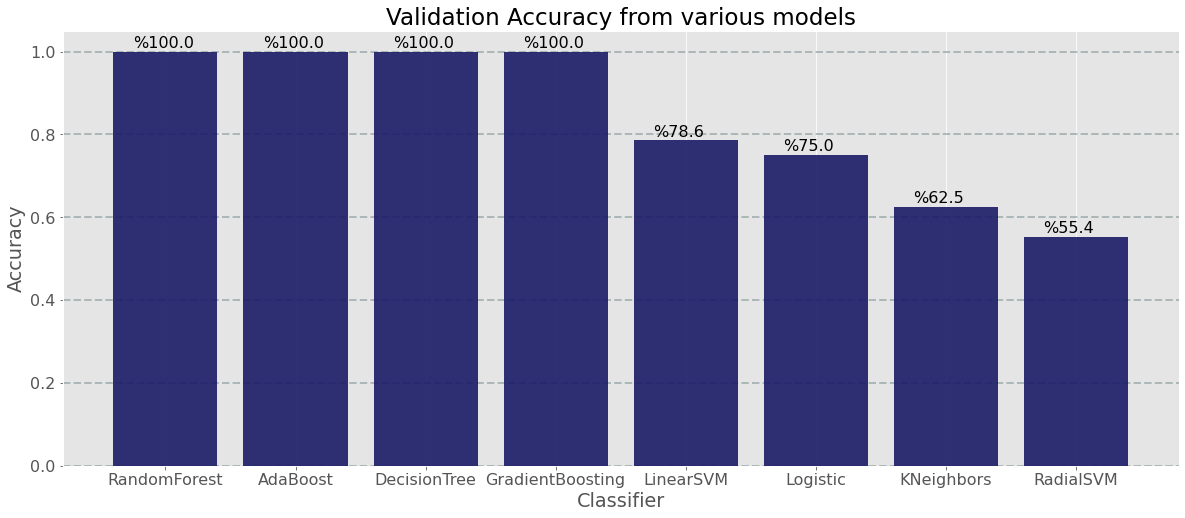

In [96]:
plt.rcParams['figure.figsize'] = [20, 8]
plt.rcParams.update({'font.size':16})
x = score1['Classifier']
val_acc = score1['Accuracy']

x_pos = [i for i, _ in enumerate(x)]

plt.bar(x_pos, val_acc, color=(0.1,0.1,0.4,0.9))
plt.xlabel("Classifier")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy from various models")
plt.grid(color='#95a5a6', linestyle='--', linewidth=2, axis='y', alpha=0.7)

plt.xticks(x_pos, x)
for i, v in enumerate(val_acc):
    plt.text(x_pos[i] - 0.25, v + 0.01, f'%{100*v:.1f}')
plt.show()

## Genetic Algorithm for Feature Selection

In [ ]:
def initilization_of_population(size,n_feat):
    population = []
    for i in range(size):
        chromosome = np.ones(n_feat,dtype=np.bool)     
        chromosome[:int(0.3*n_feat)]=False             
        np.random.shuffle(chromosome)
        population.append(chromosome)
    return population


def fitness_score(population):
    scores = []
    for chromosome in population:
        logmodel.fit(X_train.iloc[:,chromosome],Y_train)         
        predictions = logmodel.predict(X_test.iloc[:,chromosome])
        scores.append(accuracy_score(Y_test,predictions))
    scores, population = np.array(scores), np.array(population) 
    inds = np.argsort(scores)                                    
    return list(scores[inds][::-1]), list(population[inds,:][::-1]) 


def selection(pop_after_fit,n_parents):
    population_nextgen = []
    for i in range(n_parents):
        population_nextgen.append(pop_after_fit[i])
    return population_nextgen


def crossover(pop_after_sel):
    pop_nextgen = pop_after_sel
    for i in range(0,len(pop_after_sel),2):
        new_par = []
        child_1 , child_2 = pop_nextgen[i] , pop_nextgen[i+1]
        new_par = np.concatenate((child_1[:len(child_1)//2],child_2[len(child_1)//2:]))
        pop_nextgen.append(new_par)
    return pop_nextgen


def mutation(pop_after_cross,mutation_rate,n_feat):   
    mutation_range = int(mutation_rate*n_feat)
    pop_next_gen = []
    for n in range(0,len(pop_after_cross)):
        chromo = pop_after_cross[n]
        rand_posi = [] 
        for i in range(0,mutation_range):
            pos = randint(0,n_feat-1)
            rand_posi.append(pos)
        for j in rand_posi:
            chromo[j] = not chromo[j]  
        pop_next_gen.append(chromo)
    return pop_next_gen

def generations(df,label,size,n_feat,n_parents,mutation_rate,n_gen,X_train,
                                   X_test, Y_train, Y_test):
    best_chromo= []
    best_score= []
    population_nextgen=initilization_of_population(size,n_feat)
    for i in range(n_gen):
        scores, pop_after_fit = fitness_score(population_nextgen)
        #print('Best score in generation',i+1,':',scores[0])  #2
        print(f'Best score in generation {i+1}: %{100*scores[0]:.2f}')  #2
        pop_after_sel = selection(pop_after_fit,n_parents)
        pop_after_cross = crossover(pop_after_sel)
        population_nextgen = mutation(pop_after_cross,mutation_rate,n_feat)
        best_chromo.append(pop_after_fit[0])
        best_score.append(scores[0])
    return best_chromo,best_score

In [ ]:
logmodel = RandomForestClassifier(n_estimators=200, random_state=0)
X_train,X_test, Y_train, Y_test = split(df_features, y)
chromo_df_bc,score_bc = generations(df_features,
                                  y,
                                  size=80,
                                  n_feat=df_features.shape[1],
                                  n_parents=64,
                                  mutation_rate=0.20,
                                  n_gen=5,
                                  X_train = X_train,
                                  X_test = X_test,
                                  Y_train = Y_train,
                                  Y_test = Y_test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the cwd from sys.path.


Best score in generation 1: %88.24
Best score in generation 2: %91.18
Best score in generation 3: %89.71
Best score in generation 4: %92.65
Best score in generation 5: %89.71


In [ ]:
best_generation = np.argmax(score_bc)
n_selected_features = np.sum(np.array(chromo_df_bc)[best_generation,:])
n_selected_features

37